In [3]:
DATA_PATH = '../data'
TRAIN_DATA_PATH = f'{DATA_PATH}/train'
TASK_DATA_PATH = f'{DATA_PATH}/test'
TRAIN_FILENAME = f'{DATA_PATH}/train_gt.csv'
TASK_FILENAME = f'{DATA_PATH}/test.csv'

In [4]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

df = pd.read_csv(TRAIN_FILENAME, header=None, names=['audio', 'label'])
df['audio'] = TRAIN_DATA_PATH + "/" + df['audio']

x, y = df['audio'], df['label'].to_numpy().reshape(-1, 1)

weight_for_0 = (1 / (len(y) - np.sum(y))) * (len(y) / 2.0)
weight_for_1 = (1 / np.sum(y)) * (len(y) / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 0.7903573352486982, 1: 1.3610080395794681}


In [3]:
#from rnnoise_wrapper import RNNoise
from pydub import AudioSegment
import python_speech_features as psf


def preprocess_function(audio_path):
    segment = AudioSegment.from_mp3(audio_path)

    inputs = psf.mfcc(
        np.array(segment.get_array_of_samples()), segment.frame_rate
    )

    return inputs.reshape(-1, 13, 1)

def pad_each(x, size=1500):
    new_x = []

    for i in tqdm(x):
        if i.shape[0] > size:
            new_x.append(i[:size])
        else:
            new_x.append(np.pad(i, [(0, size-len(i)), (0, 0), (0, 0)]))

    return new_x

In [4]:
# features_list = []

# for audio in tqdm(x):
#     features_list.append(preprocess_function(audio))

# features_list = pad_each(features_list)

# X = np.stack(features_list)

In [6]:
X = np.load('../x_mfcc_cached.npy')

In [7]:
X[0].shape

(1500, 13, 1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

print('Относительное количество положительный записей')
print(f'Вся выборка: {sum(y) / len(y)}')
print(f'Обучающая выборка: {sum(y_train) / len(y_train)}')
print(f'Валидационная выборка: {sum(y_test) / len(y_test)}')

Относительное количество положительный записей
Вся выборка: [0.36737476]
Обучающая выборка: [0.3649789]
Валидационная выборка: [0.37296479]


In [10]:
import maximal as ml
from maximal.layers import Attention
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model

In [11]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv = Sequential([
      Conv2D(64, (5, 3), activation='relu'),
      MaxPooling2D(pool_size=(8, 2)),
      Conv2D(64, (5, 2), activation='relu'),
      MaxPooling2D(pool_size=(8, 2)),
      Conv2D(128, (5, 2), activation='relu'),
    ])
    self.attention = Attention(depth=3)
    self.flatten = Flatten()
    self.denses = Sequential([
      Dense(256, activation='relu'),
      Dense(1, activation='sigmoid')
    ])


  def call(self, x):
    x = self.conv(x)
    x = self.attention(x, x, x)
    x = self.flatten(x)
    x = self.denses(x)
    return x

model = MyModel()

In [12]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.SGD(momentum=0.5, learning_rate=0.01)

custom_callbacks = [
    EarlyStopping(
        monitor='val_f1_score',
        min_delta=1e-5,
        patience=15,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    ),
    ModelCheckpoint(
        './saves/cnn_mfcc_checkpoints/checkpoint.weights.h5',
        monitor='val_f1_score',
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode='auto',
        save_freq='epoch'
    )
]

model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy', tf.keras.metrics.F1Score(average='macro',
                                                  threshold=0.5)]
)

hist = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    validation_split=0.2, 
    epochs=200, 
    callbacks=custom_callbacks, 
    verbose=1, 
    shuffle=True, 
    class_weight=class_weight
)

Epoch 1/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.4940 - f1_score: 0.4365 - loss: 0.7640 - val_accuracy: 0.5036 - val_f1_score: 0.4038 - val_loss: 0.6934
Epoch 2/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.4985 - f1_score: 0.4836 - loss: 0.6926 - val_accuracy: 0.4116 - val_f1_score: 0.5174 - val_loss: 0.6950
Epoch 3/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.5015 - f1_score: 0.4302 - loss: 0.6935 - val_accuracy: 0.4854 - val_f1_score: 0.4125 - val_loss: 0.7007
Epoch 4/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.5172 - f1_score: 0.4041 - loss: 0.6916 - val_accuracy: 0.5403 - val_f1_score: 0.3978 - val_loss: 0.6901
Epoch 5/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5117 - f1_score: 0.4441 - loss: 0.6962 - val_accuracy: 0.5449 - val_f1_score: 0.3439 - val_loss: 0.6910
Epoch 6/200
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.5484 - f1_score: 0.4010 - loss: 0.6918 - val_accuracy: 0.5275 - va

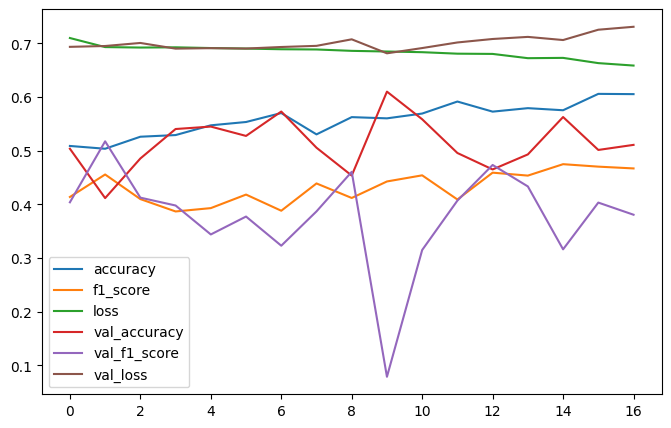

In [13]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

In [ ]:
pred = model.predict(X)
print(np.sum(pred) / len(pred))
model.evaluate(X, y, return_dict=True)

(32, 11, 1, 3)
271/276 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step(None, 11, 1, 3)
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
0.48959278131389866
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6227 - f1_score: 0.5144 - loss: 0.6532


{'accuracy': 0.6172895431518555,
 'f1_score': 0.5139228701591492,
 'loss': 0.6526318192481995}

In [ ]:
pred = model.predict(X_test)
print(np.sum(pred) / len(pred))
model.evaluate(X_test, y_test, return_dict=True)

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
0.4903810812369841
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5209 - f1_score: 0.4040 - loss: 0.7499


{'accuracy': 0.5104126930236816,
 'f1_score': 0.3926725685596466,
 'loss': 0.758514404296875}

In [ ]:
model.save('saves/cnn_mfcc.keras')

## Task

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
task = pd.read_csv(TASK_FILENAME, header=None, names=['audio', 'label'])
task['audio'] = TASK_DATA_PATH + "/" + task['audio']

task_x = task['audio']

In [ ]:
task_features_list = []

for audio in tqdm(task_x):
    task_features_list.append(preprocess_function(audio))

task_features_list = pad_each(task_features_list)

task_X = np.stack(task_features_list)

100%|██████████| 2870/2870 [00:00<00:00, 18632.61it/s]


In [ ]:
task_y = model.predict(task_X)
task_y = np.round(task_y).astype(int)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
submit = pd.read_csv(TASK_FILENAME, header=None, names=['audio', 'label'])
submit['label'] = task_y
submit.to_csv('submit.csv', header=False, index=False)